# E-Mini S&P500先物の日足データ分析

まずは
- 可視化
- TDWを調べる

In [32]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime
import locale

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

In [2]:
df = pd.read_csv('data/e-mini-sp500-200530/e-mini-sp500-daily.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5729 entries, 0 to 5728
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5729 non-null   object 
 1   Time    5729 non-null   object 
 2   Open    5729 non-null   float64
 3   High    5729 non-null   float64
 4   Low     5729 non-null   float64
 5   Close   5729 non-null   float64
 6   Vol     5729 non-null   int64  
 7   OI      5729 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 358.2+ KB


In [3]:
df.head()

,Date,Time,Open,High,Low,Close,Vol,OI
0,09/11/1997,17:00,1071.25,1082.25,1062.75,1068.50,11825,2909
1,09/12/1997,17:00,1070.50,1089.00,1066.00,1071.25,9759,4059
2,09/15/1997,17:00,1086.00,1092.25,1081.50,1083.75,8551,3818
3,09/16/1997,17:00,1083.75,1112.50,1082.75,1108.50,11749,5314
4,09/17/1997,17:00,1108.50,1115.00,1104.00,1108.50,10849,5516


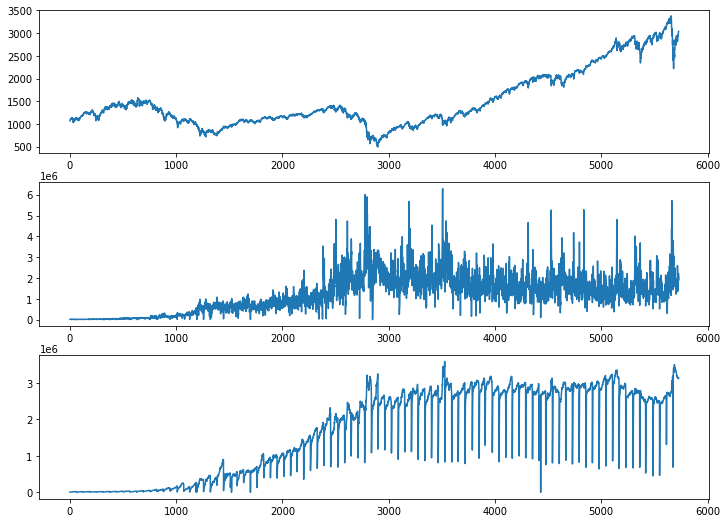

In [26]:
# 終値、出来高、建玉を可視化
fig, axs = plt.subplots(3, 1, figsize=(12, 9))
axs[0].plot(df['Close'])
axs[1].plot(df['Vol'])
axs[2].plot(df['OI'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 <a list of 100 Text major ticklabel objects>)

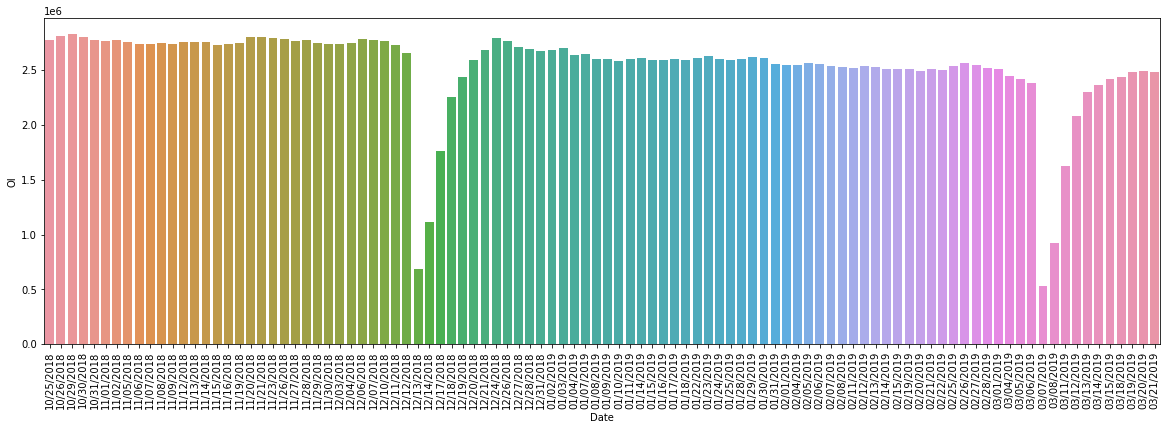

In [39]:
# Open Interest（建玉）が大きく減少するパターンが見られるので詳細を可視化
# 大体限月最終日の1～2週間前に発生しているから、おそらくロールオーバーと関係があるはず
# しかしロールオーバーの仕組みは、今の限月より次の限月の建玉が上回ったら、というルールだから、ロールオーバーしたところで建玉が大きく減るのはおかしい。
# だからロールオーバーした日ということではないはずだ。
# あるいは、トレーダーたちが大体似たようなルール（結果的に限月最終日の１～２週間前）で限月を切り替えるために、その日に急激に今の限月の建玉が減るということなのかもしれない。
# 結果としてその数日後に価格チャートがロールオーバーされるのかもしれない。
fig = plt.figure(figsize=(20, 6))
ax = sns.barplot('Date', 'OI', data=df[-400:-300])
#ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
plt.xticks(rotation=90)